In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df=pd.read_csv(r"C:\Users\ankam\OneDrive\Desktop\Research\eeg_power_data.csv")
df.head()

,Delta Power (μV²),Theta Power (μV²),Alpha Power (μV²),Beta Power (μV²),Anomaly Score
0,14,20,14,4,19.3
1,10,30,11,9,15.8
2,8,21,14,9,18.9
3,13,28,13,5,16.4
4,13,30,15,9,19.3


In [6]:
df.shape

(100, 5)

In [8]:
df.isnull().sum()

Delta Power (μV²)    0
Theta Power (μV²)    0
Alpha Power (μV²)    0
Beta Power (μV²)     0
Anomaly Score        0
dtype: int64

In [10]:
x=df.drop(columns=['Anomaly Score'])
y=df['Anomaly Score']

In [12]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=42)

In [13]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor()
model.fit(x,y)

RandomForestRegressor()

In [16]:
y_pred=model.predict(x_test)

In [18]:
import shap
explainer=shap.TreeExplainer(model)
shap_values=explainer.shap_values(x)

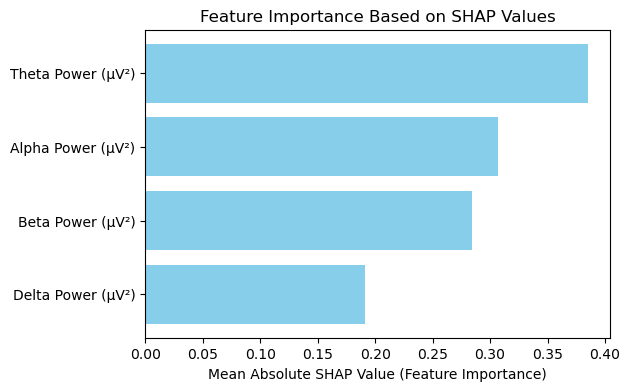

In [19]:
feature_importance = np.abs(shap_values).mean(axis=0)

# Create a DataFrame to hold feature names and importance values
feature_importance_df = pd.DataFrame({
    "Feature": x.columns,
    "Importance": feature_importance
})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Plot the feature importance bar plot
plt.figure(figsize=(6, 4))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue")
plt.xlabel("Mean Absolute SHAP Value (Feature Importance)")
plt.title("Feature Importance Based on SHAP Values")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

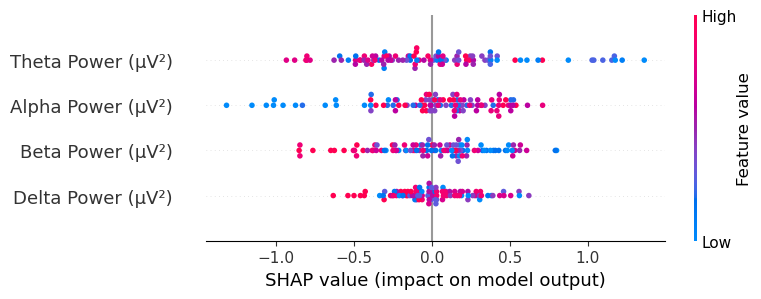

In [22]:
shap.summary_plot(shap_values, x)

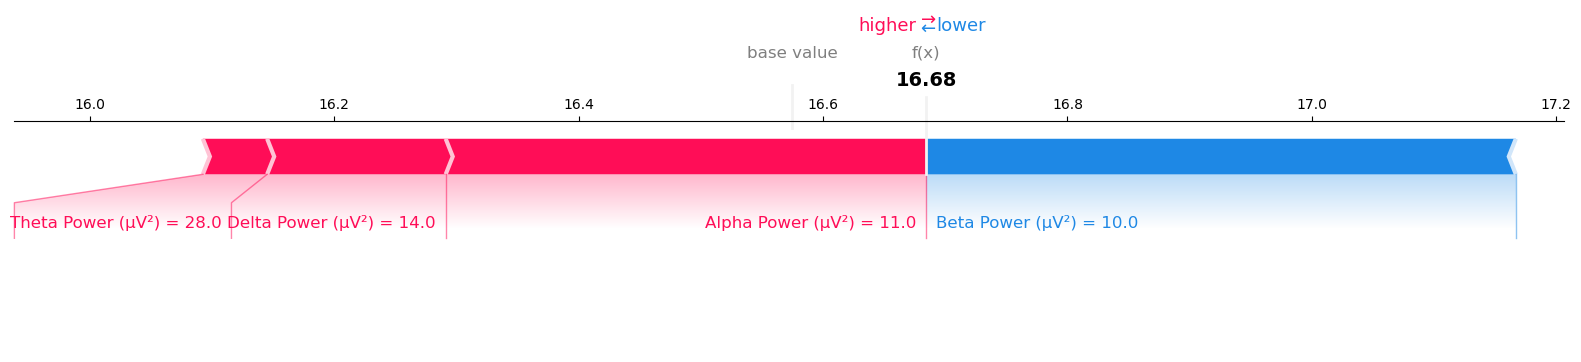

In [24]:
shap.force_plot(
        explainer.expected_value[0],  # Base value (expected value)
        shap_values[75],  # SHAP values for the selected instance
        x.iloc[75],  # Feature values for the selected instance
        matplotlib=True  # Use matplotlib for inline plots
    )
    # Display the plot
plt.show()

In [26]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
mae=mean_absolute_error(y_test,y_pred)
mse=mean_squared_error(y_test,y_pred)
r2=r2_score(y_test,y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 0.6720
Mean Squared Error (MSE): 0.5841
R² Score: 0.8360


In [28]:
import joblib

# Save the model
joblib.dump(model, "eeg_rf_model.joblib")

['eeg_rf_model.joblib']

In [30]:
streamlit_code = """
import streamlit as st
import joblib
import numpy as np
import shap
import matplotlib.pyplot as plt

# Load the trained model
model = joblib.load("eeg_rf_model.joblib")

# Set up page style
st.set_page_config(page_title="EEG Anomaly Detection", layout="wide")
st.title("🧠 EEG Anomaly Detection & SHAP Analysis")

# Sidebar Input
st.sidebar.header("🔢 Enter EEG Wave Values(in Hertz")
delta = st.sidebar.number_input("Delta Waves", min_value=0.0, format="%.2f")
theta = st.sidebar.number_input("Theta Waves", min_value=0.0, format="%.2f")
alpha = st.sidebar.number_input("Alpha Waves", min_value=0.0, format="%.2f")
beta = st.sidebar.number_input("Beta Waves", min_value=0.0, format="%.2f")

st.markdown("---")

# Prediction & SHAP Explanation
if st.sidebar.button("🚀 Predict Anomaly Score"):
    user_input = np.array([[delta, theta, alpha, beta]])
    anomaly_score = model.predict(user_input)[0]

    # Display anomaly score
    st.success(f"### 🎯 Predicted Anomaly Score: *{anomaly_score:.4f}*")

    # Anomaly detection message
    if anomaly_score > 15.0:
        st.error("⚠ *Anomaly Detected!* This EEG pattern suggests *abnormal brain activity*.")
        st.warning("🔍 Consider consulting a neurologist for further evaluation.")
    else:
        st.success("✅ *No Anomaly Detected!* This EEG pattern suggests *normal brain activity*.")
        st.info("🧠 Your brain activity appears within typical ranges. No immediate concerns detected.")

    # SHAP explanation
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(user_input)

    # SHAP Force Plot
    st.subheader("📊 SHAP Force Plot for Given EEG Inputs")

    fig, ax = plt.subplots(figsize=(10, 3))
    force_plot = shap.force_plot(
        explainer.expected_value,
        shap_values[0],
        user_input[0],
        matplotlib=True,
        show=False
    )

    plt.savefig("force_plot.png", bbox_inches="tight", dpi=300)
    st.image("force_plot.png")

    # Analyze Force Plot colors (Red = abnormal, Blue = normal)
    if np.any(shap_values[0] > 0):  # If red areas exist (positive SHAP values)
        st.error("🔴 *High-risk EEG activity detected!* Red zones indicate *strong contributors* to the anomaly.")
        st.info("🧠 This may be associated with *epileptic patterns, sleep disorders, or cognitive dysfunction.*")

st.sidebar.success("✅ Adjust values and click 'Predict' to analyze anomalies.")
"""

# Save this code as a Python file
with open("eeg_shap_app.py", "w", encoding="utf-8") as file:
    file.write(streamlit_code)

print(" Streamlit app saved as 'eeg_shap_app.py'")


 Streamlit app saved as 'eeg_shap_app.py'


In [ ]:
!streamlit run eeg_shap_app.py